# 13.2 Scaling-up model training

回顾我们在第7章中介绍的 “loop of progress” 概念：您 idea 的质量取决于它们经历了多少个 refinement cycles（见图13.1）。您可以迭代一个 idea 的速度取决于您可以以多快的速度设置实验，您可以以多快的速度运行该实验，最后，您可以分析结果数据。

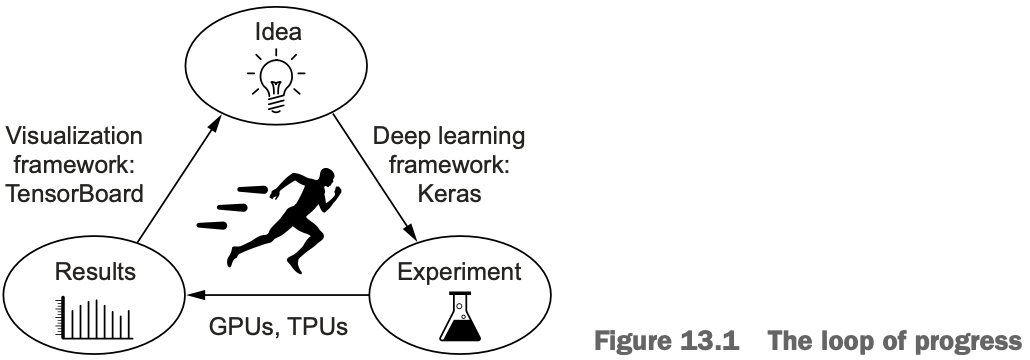

当您使用Keras API发展专业知识时，您可以以多快的速度编写深度学习实验，这不再是这个进步周期的瓶颈。下一个瓶颈将成为您训练模型的速度。快速训练基础设施意味着您可以在10-15分钟内获得结果，因此，您可以每天进行数十次迭代。更快的训练可以直接提高深度学习解决方案的质量。

在本节中，您将了解三种更快训练模型的方法：

- 混合精度训练，即使与单个GPU一起使用
- 关于多GPU的训练
- 关于TPUs的训练

## 13.2.1 Speeding up training on GPU with mixed precision

如果我告诉你，你可以用一种简单的技术来加快几乎所有模型的训练速度高达3倍，基本上是免费的呢？这种技巧确实存在。这是混合精度训练。要了解它是如何工作的，我们首先需要看看计算机科学中的 “precision” 概念。

**UNDERSTANDING FLOATING-POINT PRECISION**

精度之于数字，而分辨率之于图像。由于计算机只能处理 1和0，因此计算机看到的任何数字都必须编码为二进制字符串。例如，您可能熟悉 `uint8` 整数，它们是在8位上编码的整数：`00000000` 在 `uint8` 中代表 0，`11111111` 代表 255。要表示255以上的整数，您需要添加更多位——8位是不够的。大多数整数存储在32位上，您可以用32位表示从-2147483648到2147483647的有符号整数。

浮点数是一样的。在数学中，实数形成一个连续轴：任何两个数字之间都有无限数量的点。你总是可以在实数轴上放大。在计算机科学中，事实并非如此：例如，3到4之间有有限数量的中间点。多少？好吧，这取决于您正在处理的精度——您用于存储数字的位数。您只能放大到某个分辨率。

您通常会使用三种精度级别：

- 半精度，或 `float16`，其中数字存储在16位上
- 单精度，或 `float32`，其中数字存储在32位上
- 双精度，或 `float64`，其中数字存储在64位上

> **A note on floating-point encoding**
> 关于浮点数的一个违反直觉的事实是，可表示的数字不是均匀分布的。较大的数字精度较低：对于任意 N，2 ** N 和 2 ** （N + 1）之间的可表示值数量与1和2之间的可表示值相同。
> 这是因为浮点数被编码为三部分——sign、significant value(称为“mantissa”) 和 exponent，形式为:
> `{sign} * (2 ** ({exponent} - 127)) * 1.{mantissa}`
> 例如，以下是您如何编码近似Pi的float32值：
> 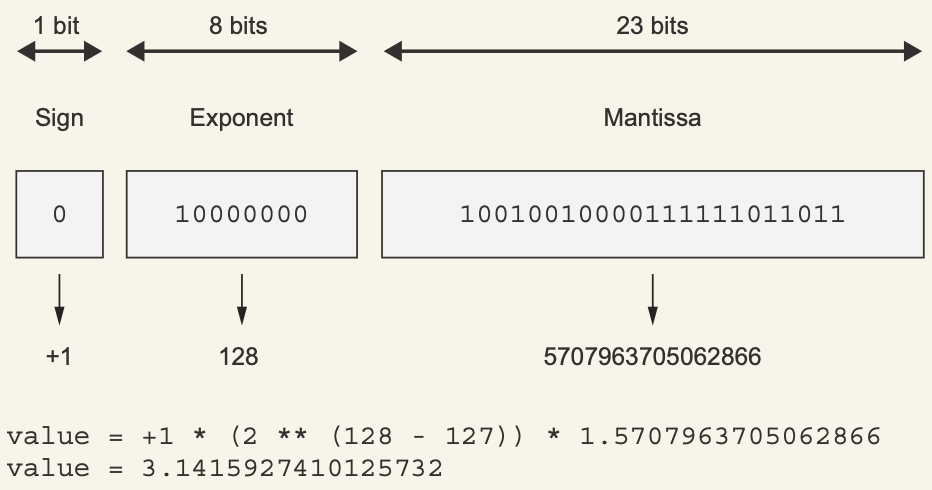
> 通过符号位、整数指数和整数mantissa以单精度编码的数字Pi
> 
> 因此，将数字转换为浮点表示时出现的数字错误可能会因所考虑的确切值而有很大差异，对于具有大绝对值的数字，误差往往会变大。


思考浮点数分辨率的方法是将您能够安全处理的两个任意数字之间的最小距离来考虑。在单精度中，大约是1e-7。在双精度方面，大约是1e-16。在半精度方面，它只有1e-3。

到目前为止，您在本书中看到的每个模型都使用单精度数字：它将状态存储为 `float32` 权重变量，并在 `float32` 输入上运行计算。这足以在不丢失任何信息的情况下前向和反向传播模型 —— 特别是当有一些小梯度更新时(回忆一下，典型的学习率为1e-3，通常看到1e-6的权重更新)。

您也可以使用 `float64`，尽管这将是浪费的——矩阵乘法或加法等操作在双精度方面要昂贵得多，因此您将做两倍的工作，而没有明显的好处。但你不能用 `float16` 权重和计算做同样的事情；梯度下降过程不会顺利运行，因为你无法表示大约 `1e-5` 或`1e-6` 的小梯度更新。

然而，您可以使用混合方法：这就是混合精度的原因。这个想法是在精度不成问题的地方利用 16 位计算，并在其他地方使用 32 位值来保持数值稳定性。现代 GPU 和 TPU 具有专用硬件，可以比等效的 32 位操作更快地运行 16 位操作，占用更少的内存。通过尽可能使用这些低精度操作，您可以通过 significant 因子加快这些设备上的训练。同时，通过将模型的精度敏感部分保持在单精度上，您可以在不影响模型质量的情况下获得这些好处。

这些好处是相当大的：在现代 NVIDIA GPU 上，混合精度可以将训练速度提高3倍。在TPU（我们稍后会讨论的子科目）上进行训练时，它也是有益的，它可以将训练速度加快高达60%。

> **Beware of dtype defaults**
> 单精度是整个 Keras 和 TensorFlow 的默认浮点类型：除非您另有说明，否则您创建的任何张量或变量都将在 `float32` 中。然而，对于NumPy数组，默认值为 `float64`！
> 
> 将默认的 NumPy 数组转换为 TensorFlow 张量将导致 `float64` tensor，这可能不是您想要的：
>
> ```
> >>> import tensorflow as tf
>>> import numpy as np
>>> np_array = np.zeros((2, 2))
>>> tf_tensor = tf.convert_to_tensor(np_array) >>> tf_tensor.dtype
tf.float64
> ```
> 转换 NumPy 数组时，请记住明确数据类型：
> ```
> >>> np_array = np.zeros((2, 2))
>>> tf_tensor = tf.convert_to_tensor(np_array, dtype="float32") >>> tf_tensor.dtype
tf.float32
> ```
> 请注意，当您使用 NumPy 数据调用 `Keras fit()` 方法时，它将为您执行此转换。


**MIXED-PRECISION TRAINING IN PRACTICE**

在GPU上训练时，您可以像这样打开混合精度：

```python
from tensorflow import keras 
keras.mixed_precision.set_global_policy("mixed_float16")
```

通常，模型的大部分正向传递将在 `float16` 中完成（softmax等数字不稳定操作除外），而模型的权重将在 `float32` 中存储和更新。

`Keras` 层具有 `variable_dtype` 和 `compute_dtype` 属性。默认情况下，两者都设置为 `float32`。当您打开混合精度时，大多数层的 `compute_dtype` 切换到 `float16`，这些层将将其输入转换为 `float16`，并在 `float16` 中执行计算（使用权重的半精度副本）。然而，由于它们的 `variate_dtype` 仍然是float32，它们的权重将能够从优化器接收准确的 `float32` 更新，而不是半精度更新。

请注意，在 `float16` 中，一些操作可能在数字上不稳定（特别是 softmax和crossentropy）。如果您需要选择退出特定层的混合精度，只需将参数 `dtype="float32"` 传递给该层的构造函数即可。

## 13.2.2 Multi-GPU training

虽然 GPU 每年都变得越来越强大，但深度学习模型越来越大，需要越来越多的计算资源。在单个 GPU 上进行训练限制您的移动速度。解决方案？您只需添加更多GPU并开始进行多GPU分布式训练。

有两种方法可以在多个设备之间分配计算： `data parallelism` 和 `model parallelism`。

通过数据并行性，单个模型可以在多台设备或多台机器上复制。每个模型副本处理不同批次的数据，然后合并结果。

通过模型并行性，单个模型的不同部分在不同的设备上运行，同时处理一批数据。这最适合具有自然并行架构的模型，例如具有多个分支的模型。

在实践中，模型并行性仅用于太大而无法安装在任何单个设备上的模型：它不是作为加快常规模型训练的一种方式，而是作为训练大型模型的一种方式。我们不会在这些页面中涵盖模型并行性；我们将专注于您大部分时间将使用的内容：数据并行性。我们来看看它是如何运作的。

**GETTING YOUR HANDS ON TWO OR MORE GPUS**

首先，您需要访问多个GPU。到目前为止，Google Colab只允许您使用单个GPU，因此您需要做两件事之一：

- 获取2-4个GPU，将其安装在一台机器上（这需要强大的电源），并安装CUDA驱动程序、cuDNN等。对于大多数人来说，这不是最好的选择。
- 在Google Cloud、Azure或AWS上租用多GPU虚拟机（VM）。您将能够将VM映像与预装驱动程序和软件一起使用，并且设置开销很少。对于任何没有全天候训练模型的人来说，这可能是最好的选择。

我们不会涵盖如何 spin up 多 GPU 云虚拟机的细节，因为此类工具将相对较短，并且这些信息可以随时在线获得。

如果您不想处理管理自己虚拟机实例的开销，您可以使用TensorFlow Cloud（[https://github.com/tensorflow/cloud](https://github.com/tensorflow/cloud)） ，这是我和我的团队最近发布的软件包——它使您只需在Colab笔记本开始添加一行代码即可开始在多个GPU上进行训练。如果您正在寻找从在Colab调试模型到在任意数量的GPU上进行训练的无缝过渡，请查看。

**SINGLE-HOST, MULTI-DEVICE SYNCHRONOUS TRAINING**

一旦您能够在具有多个GPU的机器上 `import tensorflow`，您就距离训练分布式模型只有几秒钟了。它的工作原理是这样的：

```python
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

with strategy.scope():
    model = get_compiled_model()
model.fit(
    train_dataset,
   epochs=100,
   validation_data=val_dataset,
   callbacks=callbacks)
```

这几行实现了最常见的训练设置：`single-host, multi-device synchronous training`，在 TensorFlow 中也称为 “mirrored distribution strategy”。“Single host” 意味着考虑的不同 GPU 都在一台机器上（而不是由许多机器组成的集群，每台机器都有自己的GPU，通过网络进行通信）。“Synchronous training” 意味着每个GPU模型副本的状态始终保持不变——在情况并非如此的地方，分布式训练有变体。

当您打开 `MirroredStrategy` scope 并在其中构建模型时，`MirroredStrategy` 对象将在每个可用的GPU上创建一个模型副本（副本）。然后，每个训练步骤都以以下方式展开（见图13.2）：

- 从数据集中提取一批数据（称为 `global batch`）。
- 它被分为四个不同的子批次（称为 `local batches`）。例如，如果全局批次有512个样本，则四个本地批次中的每个批次将有128个样本。因为您希望本地批次足够大，以保持GPU繁忙，全局批处理量通常需要非常大。
- 四个副本中的每个都在自己的设备上独立处理一个本地批处理：它们运行一个前向传播，然后运行一个反向传播。每个副本输出一个 “weight delta”，描述模型中每个权重变量的更新量，给定之前权重相对于模型在本地批次上损失的梯度。
- 来自本地梯度的权重增量在四个副本中高效合并，以获得全局增量，该增量适用于所有副本。由于这是在每一步结束时完成的，复制品总是保持同步：它们的权重总是相等的。

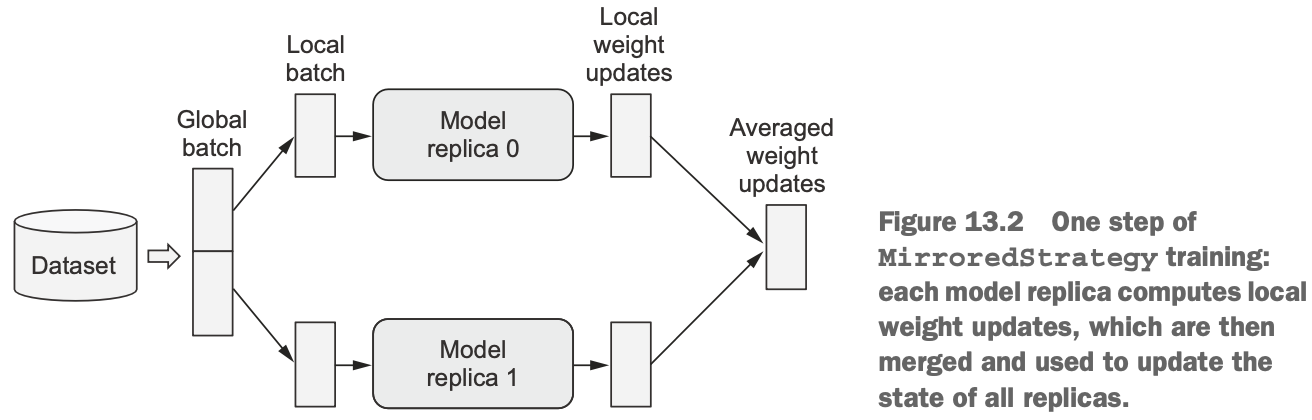

> **tf.data performance tips**
> 在进行分布式训练时，请务必将您的数据作为 `tf.data.Dataset` 对象提供，以保证最佳性能。（将数据作为 NumPy数组传递也有效，因为这些数组通过 `fit()` 转换为数据集对象）。您还应该确保利用 data prefetching：在将数据集传递给`fit()` 之前，调用 `dataset.prefetch(buffer_size)`。如果您不确定要选择什么缓冲区大小，请尝试`dataset.prefetch（tf.data.AUTOTUNE）` 选项，该选项将为您选择缓冲区大小。
> 

在一个理想的世界里, ，N GPU上的训练将导致 N 倍的加速。然而，在实践中，分布式引入了一些开销——特别是，合并来自不同设备的 weight deltas 需要一些时间。您获得的有效加速是所用 GPU 数量的函数：

- 有了2个GPU，加速保持接近2倍。
- 有了4个GPU，加速约为3.8倍。
- 有了8个GPU，加速约为7.3倍。

这假设您正在使用足够大的全局批处理大小，以保持每个 GPU 利用了全部容量。如果您的批处理大小太小，则本地批处理大小不足以让您的GPU保持忙碌。

## 13.2.3 TPU training

除了GPU外，深度学习世界还倾向于将工作流程转移到专门为深度学习工作流程设计的日益专业化的硬件（此类单一用途芯片被称为ASIC，特定于应用程序的集成电路）。各种大小公司都在开发新芯片，但今天沿着这些思路最突出的努力是谷歌的张量处理单元（TPU），该单元可在谷歌云和谷歌Colab上使用。

关于TPU的训练确实涉及跳过一些圈子，但值得额外的工作：TPU非常非常快。TPU V2上的训练通常比训练 NVIDIA P100 GPU 快15倍。对于大多数模型来说，TPU训练最终的平均成本效益是GPU训练的3倍。

**USING A TPU VIA GOOGLE COLAB**

您实际上可以在Colab中免费使用8核TPU。在Colab菜单的运行时选项卡下，在更改运行时类型选项中，您会注意到除了GPU运行时外，您还可以访问TPU运行时。

当您使用GPU运行时时，您的模型可以直接访问GPU，而无需做任何特殊的事情。对于TPU运行时来说，情况并非如此；在开始构建模型之前，您需要采取一个额外的步骤：您需要连接到TPU集群。

```python
import tensorflow as tf
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
print("Device:", tpu.master())
```

您不必太担心这会做什么——它只是一个将 Notebook 运行时连接到设备的一个小咒语。芝麻开门。

与多GPU训练非常相似，使用 TPU 需要您打开分布式策略范围——在这种情况下，`TPUStrategy` scope。`TPUStrategy` 遵循与 `MirroredStrategy` 相同的分布式模板——模型每个TPU核心复制一次，副本保持同步。


```python
from tensorflow import keras
from tensorflow.keras import layers strategy = tf.distribute.TPUStrategy(tpu)
print(f"Number of replicas: {strategy.num_replicas_in_sync}")

def build_model(input_size):
    inputs = keras.Input((input_size, input_size, 3))
    x = keras.applications.resnet.preprocess_input(inputs) 
    x = keras.applications.resnet.ResNet50(
        weights=None, include_top=False, pooling="max")(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

with strategy.scope():
    model = build_model(input_size=32)
```

我们几乎可以开始训练了。但Colab中的TPU有点好奇：这是一个双虚拟机设置，这意味着托管 Notebook 运行时的虚拟机与TPU所在的虚拟机不同。因此，您将无法从存储在本地磁盘上的文件（即链接到托管 Notebook 的虚拟机的磁盘）进行训练。TPU运行时无法从那里读取。您有两个数据加载选项：

- 从存储在虚拟机内存中的数据（而不是磁盘上）进行训练。如果您的数据在NumPy数组中，这就是您已经在做的事情。
- 将数据存储在谷歌云存储（GCS）存储桶中，并创建一个数据集，直接从存储桶读取数据，而无需在本地下载。TPU运行时可以从GCS读取数据。对于太大而无法完全存储在内存中的数据集，这是您唯一的选择。

在我们的例子中，让我们从内存中的NumPy数组——CIFAR10数据集进行训练：

```python
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
model.fit(x_train, y_train, batch_size=1024)
```

您会注意到，第一个 epoch 需要一段时间才能开始——这是因为您的模型正在编译成TPU可以执行的内容。一旦完成这一步，训练本身就会很快。

> **Beware of I/O bottlenecks**
> 由于TPU可以非常快速地处理批次数据，因此您可以从GCS读取数据的速度很容易成为一个瓶颈。 
> - 如果您的数据集足够小，您应该将其保存在虚拟机的内存中。您可以通过在数据集上调用 `dataset.cache()` 来做到这一点。这样，数据只会从GCS读取一次。
> - 如果您的数据集太大而无法放入内存，请确保将其存储为 TFRecord 文件——这是一种高效的二进制存储格式，可以非常快速加载。在keras.io上，您将找到一个代码示例，演示如何将数据格式化为 TFRecord 文件（[https://keras.io/examples/keras_recipes/creating_tfrecords/](https://keras.io/examples/keras_recipes/creating_tfrecords/)） 。

**LEVERAGING STEP FUSING TO IMPROVE TPU UTILIZATION**

由于TPU有很多可用的计算能力，因此您需要使用非常大的批次进行训练，以保持TPU核心的繁忙。对于小型模型，所需的批次尺寸可能会非常大——每批超过10,000个样本。在处理大量的批次时，您应该确保一致地提高优化器的学习率；您将对权重进行更少的更新，但每次更新将更准确（因为梯度是使用更多数据点计算的），因此您应该在每次更新中将权重移动得更大。

然而，您可以利用一个简单的技巧来保持合理大小的批次，同时保持完整的TPU利用率：`step fusing`。这个想法是在每个TPU执行步骤中运行多个训练步骤。基本上，在从 VM 内存到 TPU 的两次往返之间做更多的工作。为此，只需在 `compile()` 中指定 `steps_ per_execution` 参数 — 例如， `steps_per_execution=8` 在每次 TPU 执行期间运行八个训练步骤。对于未充分利用 TPU 的小型模型，这可能会导致大幅加速。

## Summary

- 您可以利用超参数调优和KerasTuner来自动化单调乏味，以找到最佳模型配置。但要注意验证集过拟合！
- 一系列不同的模型通常可以显著提高预测的质量。
- 您可以通过打开混合精度来加快GPU上的模型训练——您通常几乎可以免费获得良好的速度提升。
- 为了进一步扩展您的工作流程，您可以使用 `tf.distribute.MirroredStrategy` API 在多个GPU上训练模型。
- 您甚至可以使用 `TPU-Strategy` API在谷歌的TPU（可在Colab上提供）上进行训练。如果您的模型很小，请确保利用 `ste `（通过编译（...，steps_per_execution=N）参数），以充分利用TPU内核。